In [133]:
import copy
# ------------------------------
import pandas as pd
import numpy as np
# ------------------------------
import seaborn as se
import matplotlib.pyplot as plt

# Описание выбранного набора данных и решаемая задача

Тема курсовой работы **"Байесовская оптимизация для настройки гипперапараметров моделей машинного обучения"**

Задача: применение на практике байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения.

Перед выполнением поставленной задачи курсовой работы необходимо определить решаему задачу в области машщинного обучения и данные её характеризующие, выбрать модель в равной степени хорошо подходящую для решения обеих задач.

В качетсве решаемой задачи машинного обучения выбрана задача кредитного скорринга, то есть классификация клиента как "одобрить кредит" или "не одобрить кредит" по некторому набору признаков. Набор данных взять с сайта [kaggle](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview), ниже приведено подробное описание набора данных.

Набор данных представляет собой набор файлов в формате csv разбитый на обучающую (cs-training) и тестовые (cs-test) выборки. Обучающая выборка содержит 150.000 объектов, тестовая - 102.000 объектов. Все объекты описываются 11 признаками:
- **SeriousDlqin2yrs** - Лицо имело просроченную задолженность на 90 дней или более;
- **RevolvingUtilizationOfUnsecuredLines** - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и отсутствия задолженности по рассрочке;
- **age** - Возраст заемщика в годах;
- **NumberOfTime30**-59DaysPastDueNotWorse - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше, за последние 2 года;
- **DebtRatio** - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход;
- **MonthlyIncome** - Ежемесячный доход;
- **NumberOfOpenCreditLinesAndLoans** - Количество открытых кредитов (кредиты с рассрочкой платежа, например, автокредит или ипотека) и кредитных линий (например, кредитные карты);
- **NumberOfTimes90DaysLate** - Количество просрочек заемщика на 90 дней и более;
- **NumberRealEstateLoansOrLines** - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья;
- **NumberOfTime60-89DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года;
- **NumberOfDependents** - Количество иждивенцев в семье, не считая их самих (супруг(а), дети и т. д.).

Каждый из них является численным, поэтому  вдальнейшем не появится необходимости конструирования корректного численного представления категориальных данных.

В данной работе для оптимизации выбрана модель дерева решений по ряду причин:
- Легкость настройки - ряд ключевых гипперпараметров модели представляют собой целочисленные значения, что значительно облегчит применение байесовской оптимизации;
- Хороший baseline - построенная и оптимизированная модель послужит хорошей основой для дальнейшей работы и улучшения результатов;

# Предварительный анализ и очистка данных

## Информация о наборе данных

In [134]:
data = pd.read_csv("data/cs-training.csv", index_col=0)
display(data.head()), display(data.info()), display(data.describe())

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

None

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


(None, None, None)

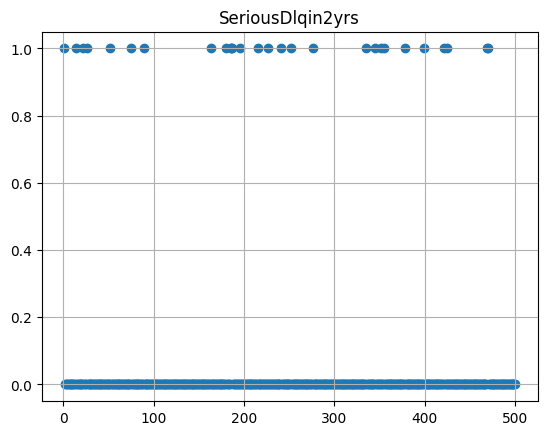

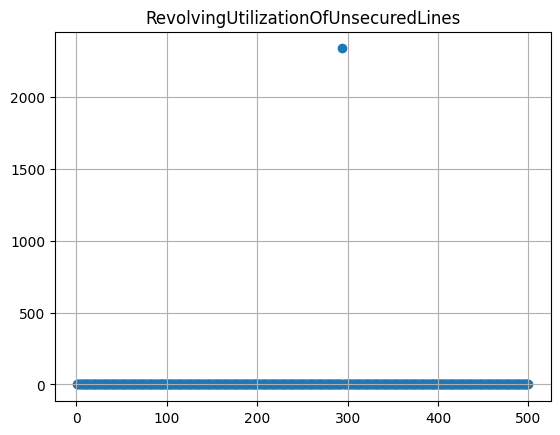

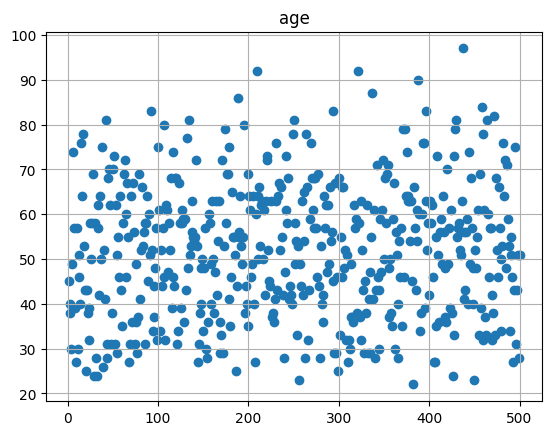

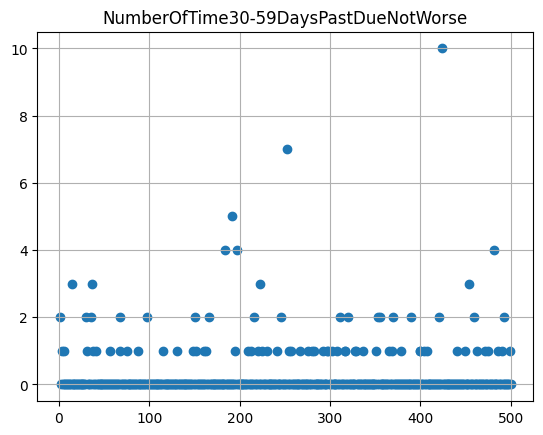

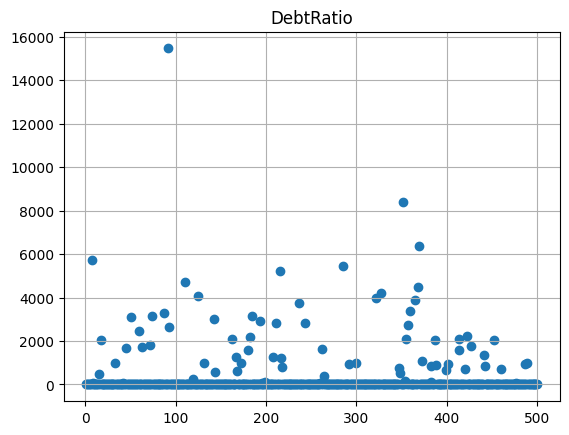

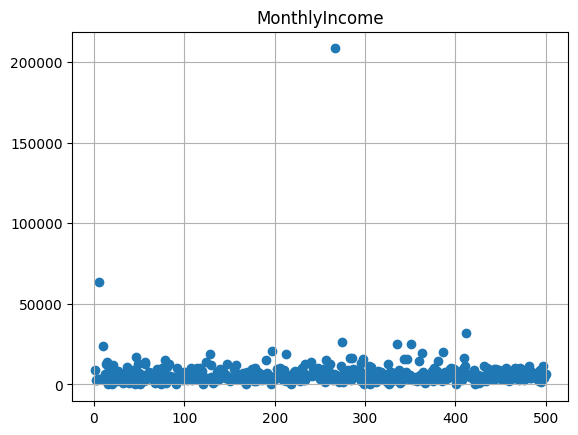

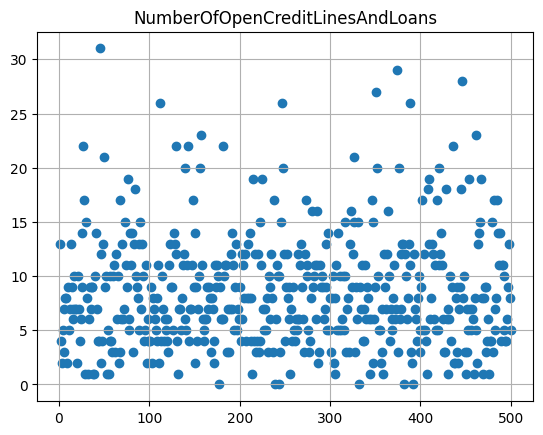

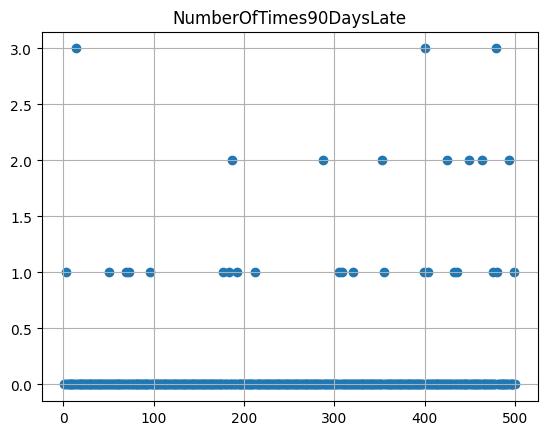

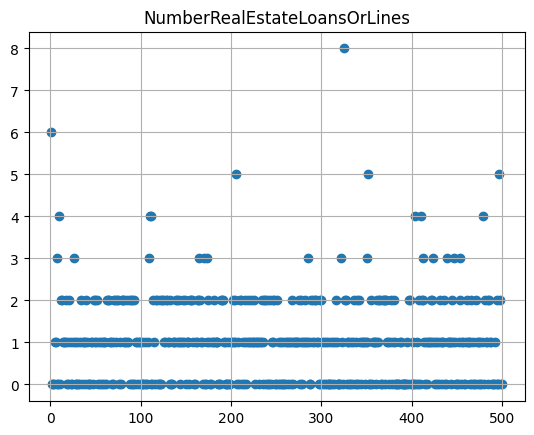

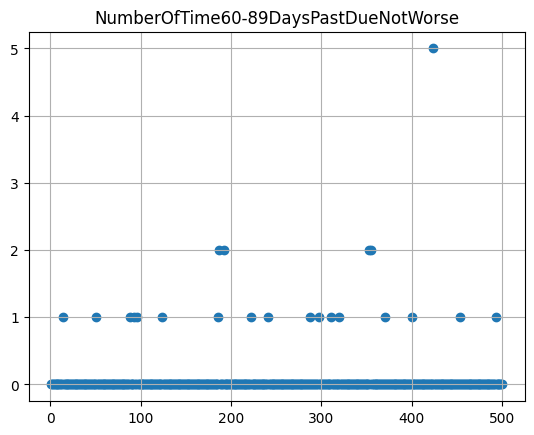

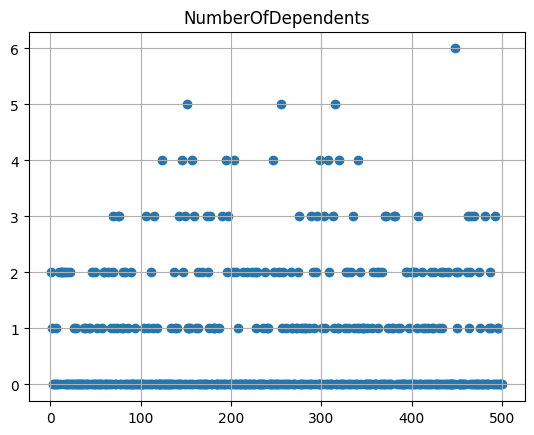

In [135]:
for column in data.columns:
    data_on_scatter = data.head(500)
    plt.title(column)
    plt.scatter(x=data_on_scatter.index.values, y=data_on_scatter[column].values)
    plt.grid()
    plt.show()

In [136]:
print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Описательный анализ данных 

### Удаление пропусков в наборе данных

Как видно выше, пропуски имеются в признаках MonthlyIncome и NumberOfDependents. Объекты с пропусками не удаляются, так как будет потеряна не малая часть обучающей выборки, но пропуски будут заменены медианными значениями. 

In [137]:
nan_index_MonthlyIncome = data[data["MonthlyIncome"].isna() == True].index
nan_index_NumberOfDependents = data[data["NumberOfDependents"].isna() == True].index
median_MonthlyIncome = data["MonthlyIncome"].median()
median_NumberOfDependents = data["NumberOfDependents"].median()
data.loc[nan_index_MonthlyIncome, "MonthlyIncome"] = median_MonthlyIncome
data.loc[nan_index_NumberOfDependents, "NumberOfDependents"] = median_NumberOfDependents

print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Поиск и удаление выбросов

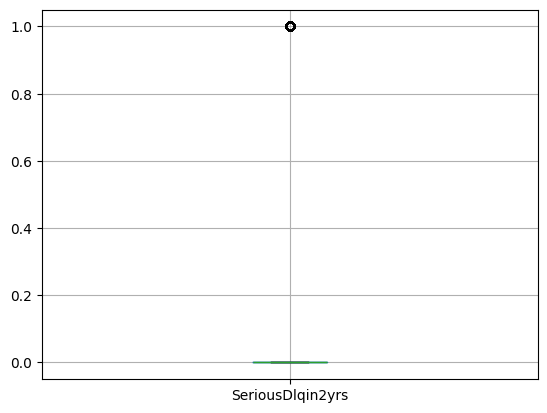

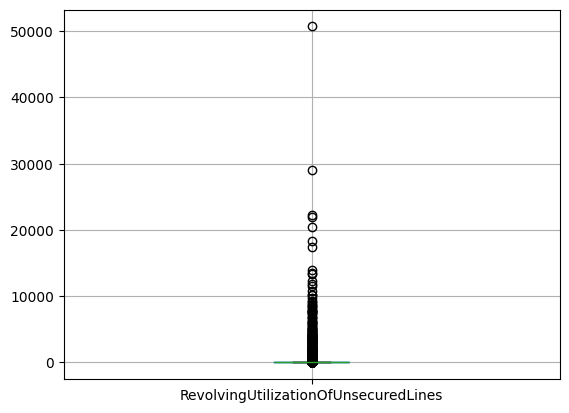

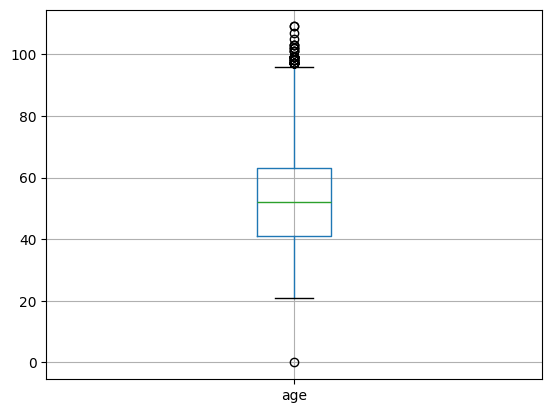

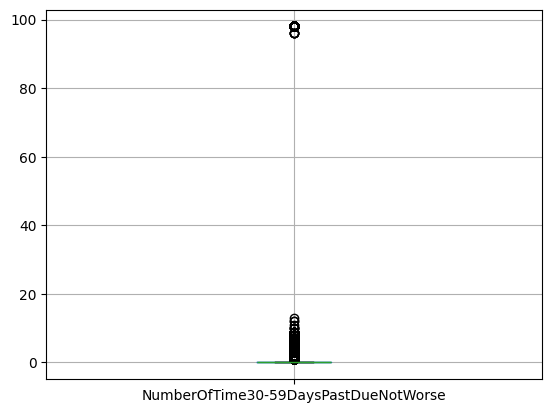

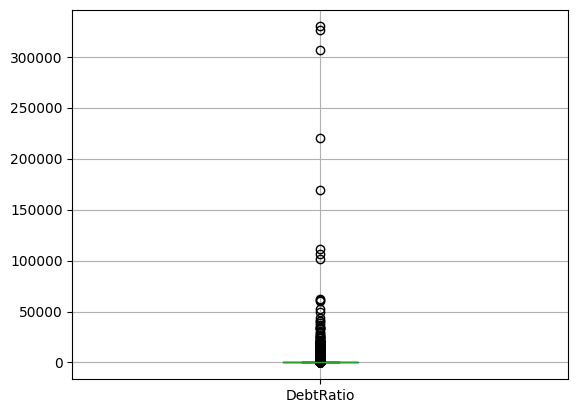

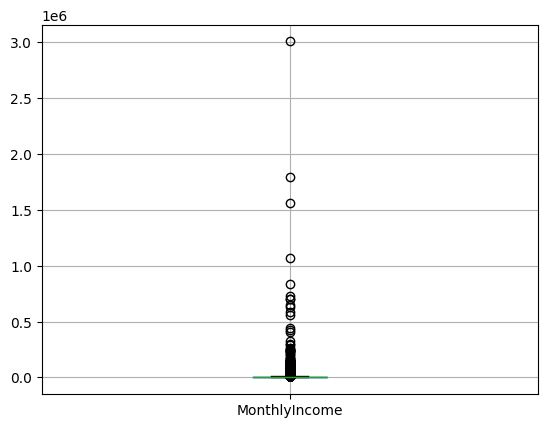

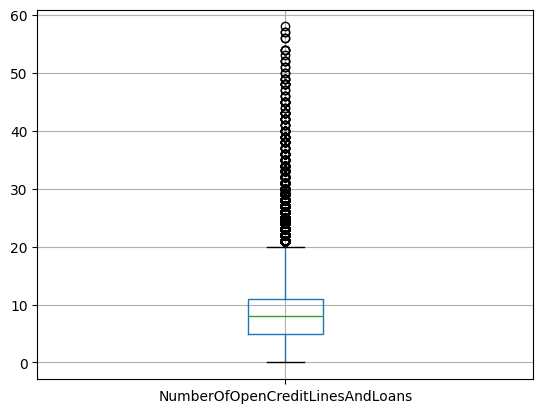

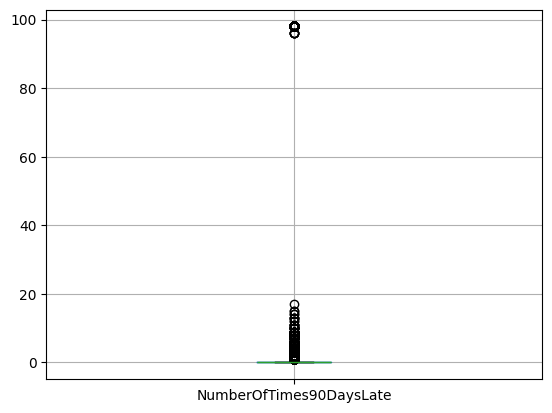

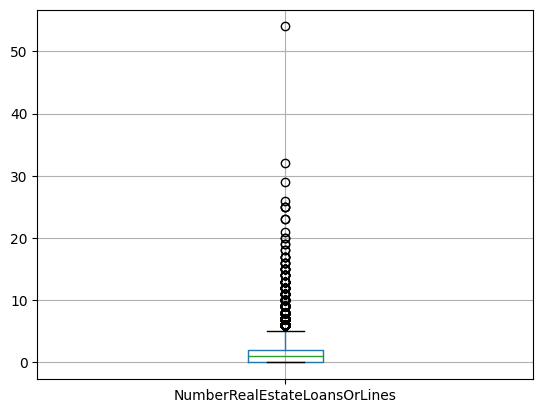

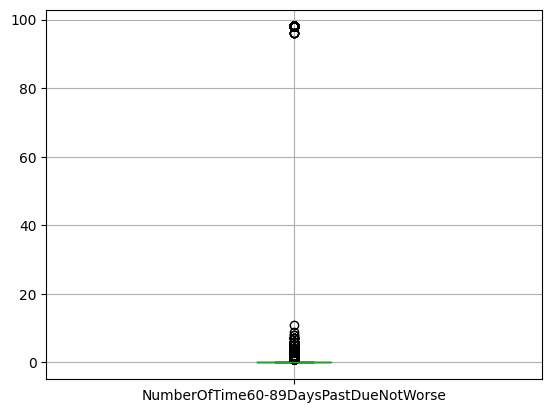

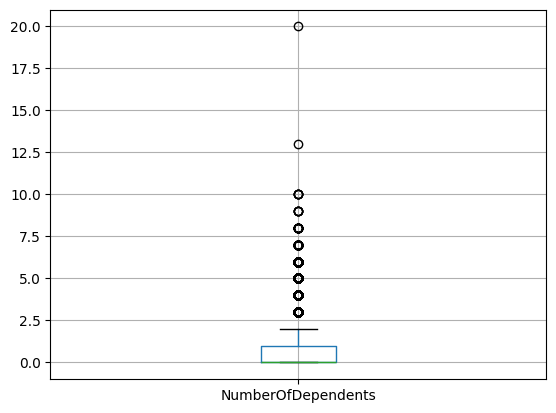

In [138]:
for col in data.columns:
    plt.subplots(1, 1)
    pd.DataFrame(data[col]).boxplot()
    plt.show()

Сначала будут удалены те объекты чьё значение "age" превыщает полтора квартильного размаха или которое меньше 18 лет. Нижняя допустимая граница возраста выбрана из предположения, что, в среднем, человек начинает зарабатывать деньги и, следоватльно, имеет возможность взять кредит, с 18 лет.

Другие, пока что, заменяю на медиану. Кроме NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, так как, в основном, они равны нулю и выюросы в этих признаках несут важную инфорацию. 

In [139]:
topline = data["age"].quantile(0.75) + (data["age"].quantile(0.75) - data["age"].quantile(0.25)) * 1.5 
downline = 18
data = data.drop(data["age"][data["age"] > topline].index)
data = data.drop(data["age"][data["age"] < downline].index)

In [140]:
another_columns = set(data.columns) - set(["age", "SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"])
for column in another_columns:
    Q1, Q3 = data[column].quantile(0.25), data[column].quantile(0.75)
    IRQ = Q3 - Q1 
    topline = Q3 + IRQ * 1.5 
    downline = Q1 - IRQ * 1.5 
    median = data[column].median()
    data.loc[data[data[column] > topline].index, column] = median
    data.loc[data[data[column] < downline].index, column] = median

Теперь построим гистограмму распределения данных и обратим внимание на дизбаланс классов в таргете, а именнно на графике "SeriousDlqin2yrs".

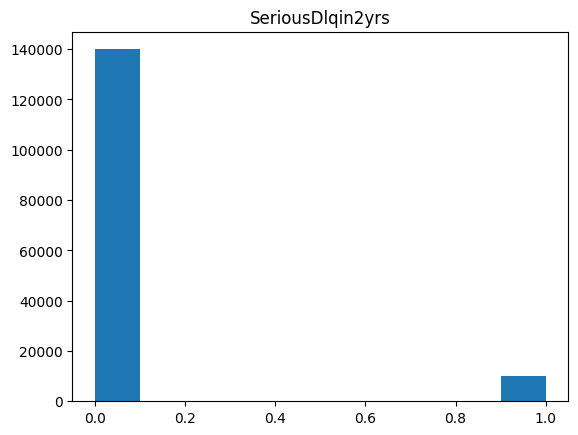

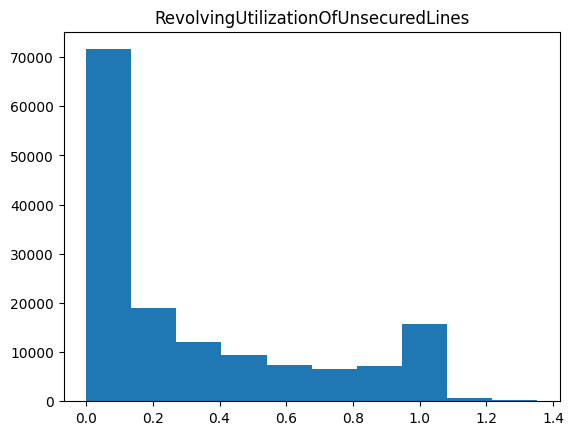

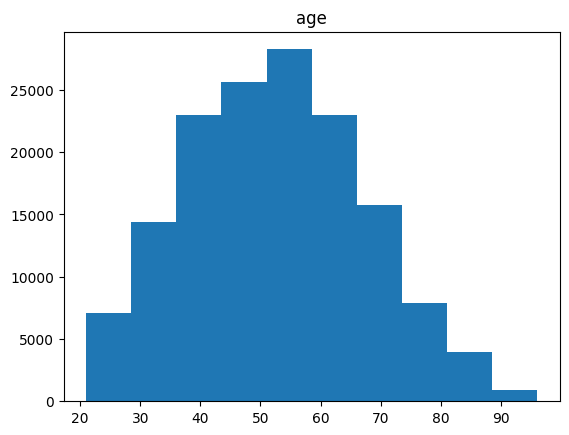

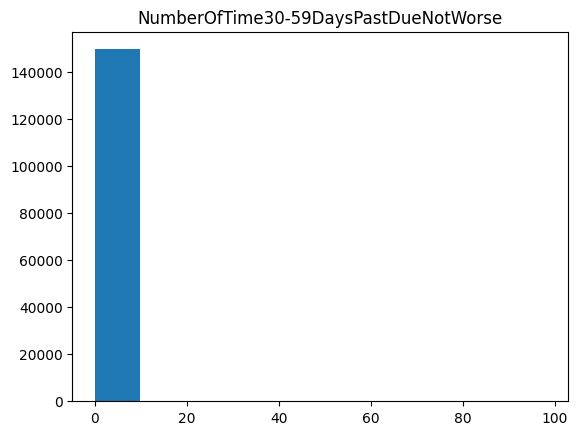

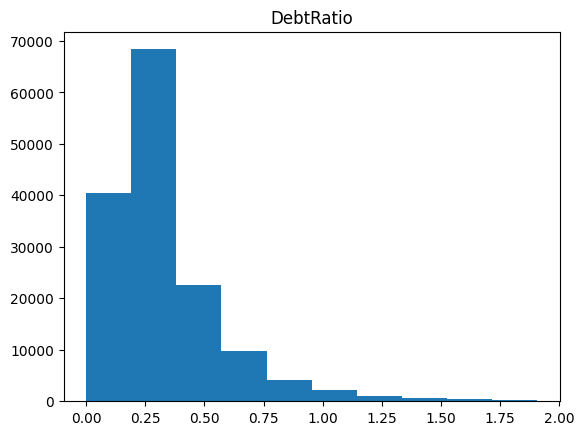

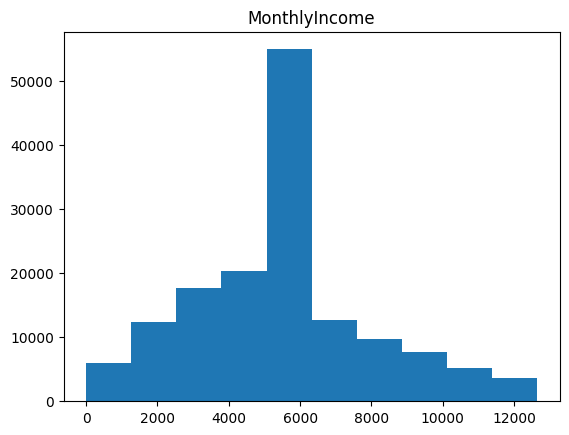

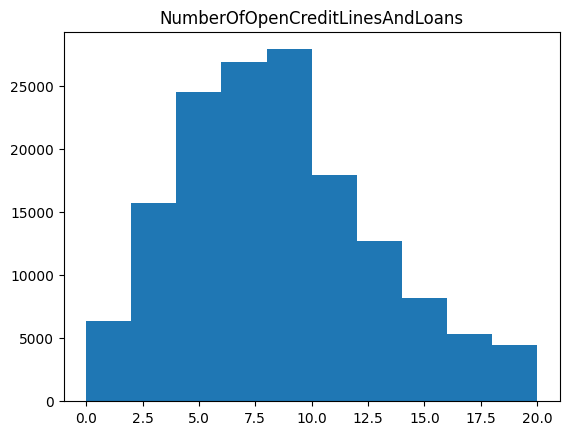

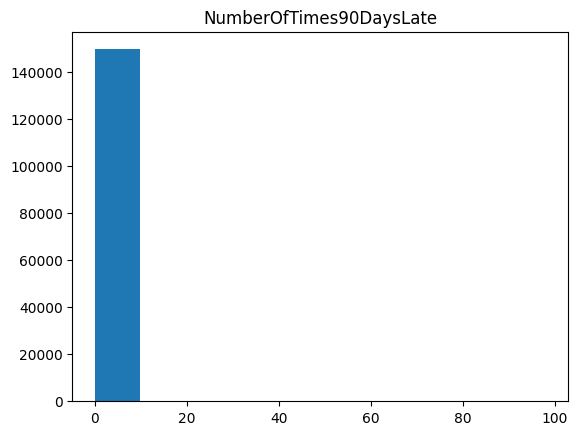

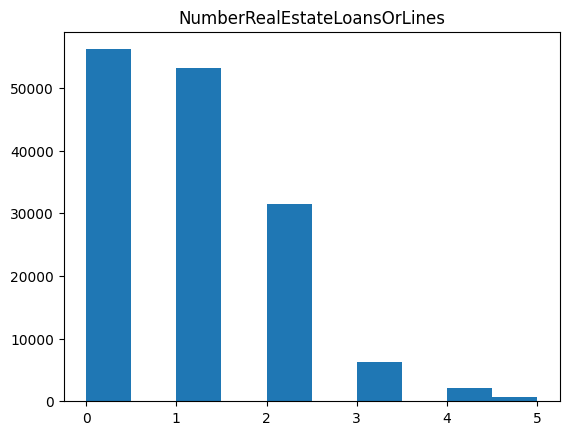

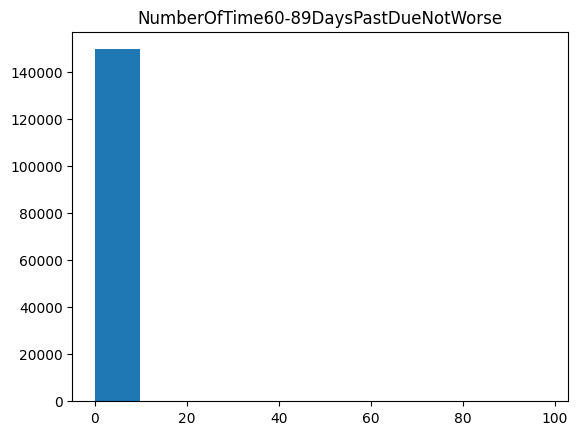

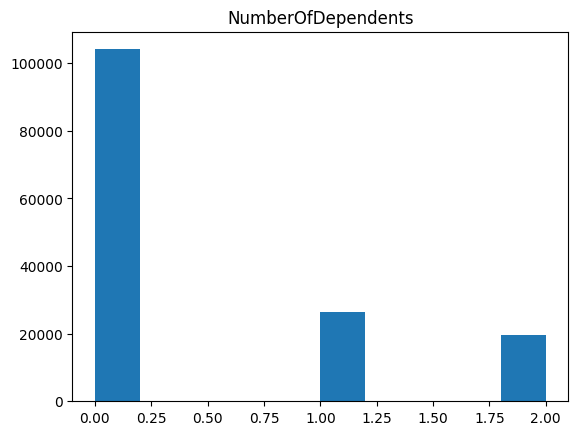

In [141]:
for column in data.columns:
    plt.title(column)
    data[column].hist()
    plt.grid()
    plt.show()

## Построим корреляционную матрицу

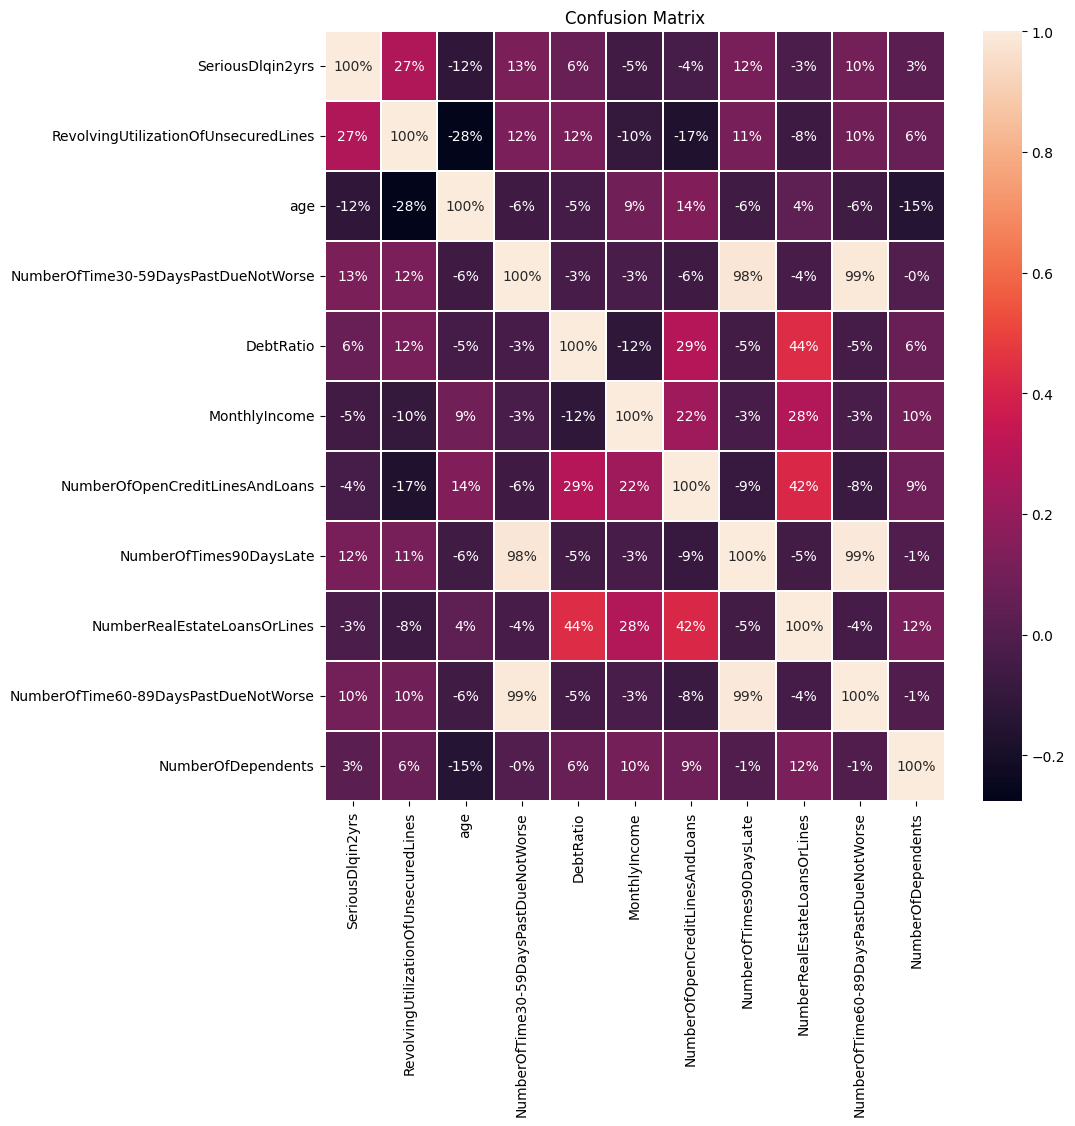

In [142]:
def draw_cov(data):
    figsize = (10,10)
    fig, ax = plt.subplots(figsize=figsize)
    plt.title('Confusion Matrix')
    se.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

draw_cov(data)

## Убираем признаки сильнокоррелирующие друг с другом

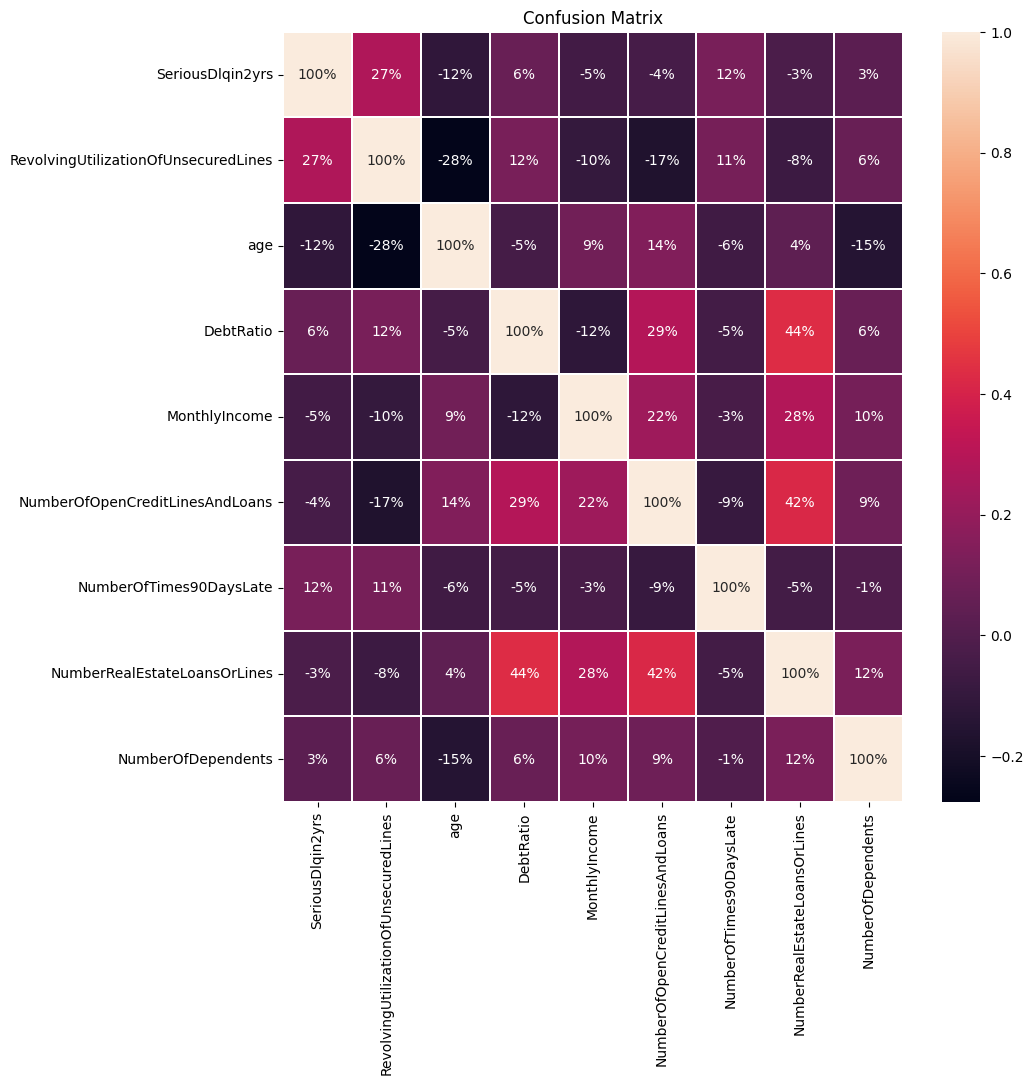

In [143]:
datacopy = copy.copy(data)
datacopy = datacopy.drop("NumberOfTime60-89DaysPastDueNotWorse", axis=1)
datacopy = datacopy.drop("NumberOfTime30-59DaysPastDueNotWorse", axis=1)
draw_cov(datacopy)

In [144]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,1,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,5400.0,7,0,1,0,0.0


In [235]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


X, y = data[data.columns[1:]], data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)  

pipline = make_pipeline(StandardScaler(), DecisionTreeClassifier())
model = pipline.fit(X_train, y_train)
model.score(X_test, y_test)

0.9073333333333333

In [236]:
from sklearn.naive_bayes import GaussianNB

pipline = make_pipeline(StandardScaler(), GaussianNB())
model = pipline.fit(X_train, y_train)
model.score(X_test, y_test)

0.944

In [ ]:
test = pd.read_csv("data/cs-test.csv", delimiter=',', index_col=0)

model.predict_proba()